Test Accuracy (SVM): 74.90%
Classification Report (SVM):
                 precision    recall  f1-score   support

      Positive       0.89      0.96      0.92      1218
      Negative       0.75      0.68      0.71      1257
  Not_relevant       0.72      0.71      0.71      1312
Mixed Feelings       0.64      0.67      0.65      1238
       Neutral       0.75      0.73      0.74      1262

      accuracy                           0.75      6287
     macro avg       0.75      0.75      0.75      6287
  weighted avg       0.75      0.75      0.75      6287



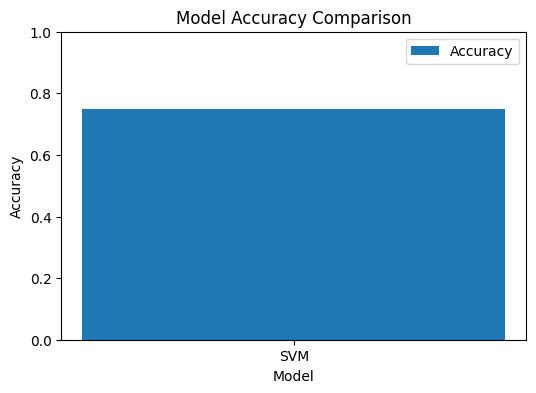

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load data from CSV
file_path = 'final_manglish.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Ensure 'commentText' column contains strings
data['commentText'] = data['commentText'].astype(str)

# Function to convert sentiment labels to numerical values
sentiment_dict = {
    'Positive': 0,
    'Negative': 1,
    'Not_relevant': 2,
    'Mixed Feelings': 3,
    'Neutral': 4
}

data['Sentiment_Class'] = data['Sentiment_Class'].map(sentiment_dict)

# Tokenization and sequence padding
max_words = 1000
max_seq_length = 100
vectorizer = CountVectorizer(max_features=max_words)
X = vectorizer.fit_transform(data['commentText'])
y = data['Sentiment_Class']

# Upsample minority classes to match the size of the majority class
data_upsampled = pd.concat([
    resample(data[data['Sentiment_Class'] == sentiment_dict['Positive']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Negative']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Mixed Feelings']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Neutral']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']]))
])

# Tokenization and sequence padding for balanced data
X_upsampled = vectorizer.fit_transform(data_upsampled['commentText'])
y_upsampled = data_upsampled['Sentiment_Class']

# Split the upsampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_upsampled, y_upsampled, test_size=0.2, random_state=10)

# Build and train SVM model
svm_model = SVC(kernel='linear', random_state=42)  # Using a linear kernel, you can also try other kernels like 'rbf'
svm_model.fit(X_train, y_train)

# Evaluate the SVM model on test data
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Test Accuracy (SVM): {accuracy_svm * 100:.2f}%")

# Generate predictions for SVM
reverse_sentiment_dict = {v: k for k, v in sentiment_dict.items()}
y_test_labels = [reverse_sentiment_dict[label] for label in y_test]
y_pred_labels_svm = [reverse_sentiment_dict[label] for label in y_pred_svm]

# Print complete classification report for SVM
print("Classification Report (SVM):\n", classification_report(y_test_labels, y_pred_labels_svm, target_names=sentiment_dict.keys()))

# Plotting the accuracy comparison (SVM only)
plt.figure(figsize=(6, 4))
plt.bar(['SVM'], [accuracy_svm], width=0.4, label='Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.legend()
plt.show()


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data from CSV
file_path = 'final_manglish.csv'
data = pd.read_csv(file_path)

# Ensure 'commentText' column contains strings
data['commentText'] = data['commentText'].astype(str)

# Function to convert sentiment labels to numerical values
sentiment_dict = {
    'Positive': 0,
    'Negative': 1,
    'Not_relevant': 2,
    'Mixed Feelings': 3,
    'Neutral': 4
}

data['Sentiment_Class'] = data['Sentiment_Class'].map(sentiment_dict)

# Upsample minority classes to match the size of the majority class
data_upsampled = pd.concat([
    resample(data[data['Sentiment_Class'] == sentiment_dict['Positive']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Negative']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Mixed Feelings']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Neutral']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']]))
])

# Tokenization and Embedding Extraction with BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased').to(device)

def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    inputs.to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Extract CLS token embeddings
    return embeddings

# Use tqdm for progress bar during embedding extraction
tqdm.pandas()
data_upsampled['bert_embeddings'] = data_upsampled['commentText'].progress_apply(get_bert_embeddings)

# Flatten BERT embeddings
X_upsampled = np.vstack(data_upsampled['bert_embeddings'])
y_upsampled = data_upsampled['Sentiment_Class']

# Split the upsampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_upsampled, y_upsampled, test_size=0.2, random_state=10)

# Build and train SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Evaluate the SVM model on test data
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Test Accuracy (SVM): {accuracy_svm * 100:.2f}%")

# Print complete classification report for SVM
print("Classification Report (SVM):\n", classification_report(y_test, y_pred_svm))

# Plotting the accuracy comparison (SVM only)
# Note: BERT embeddings might not be suitable for visualization in a bar plot due to high dimensionality


100%|██████████| 31435/31435 [09:27<00:00, 55.35it/s]


Test Accuracy (SVM): 67.03%
Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.64      0.64      0.64      1262
           1       0.59      0.59      0.59      1257
           2       0.58      0.54      0.56      1238
           3       0.76      0.90      0.83      1218
           4       0.77      0.68      0.72      1312

    accuracy                           0.67      6287
   macro avg       0.67      0.67      0.67      6287
weighted avg       0.67      0.67      0.67      6287

